#**Evaluation homework**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

df.head(10)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
5,events,manufacturing,1,59904.0,NaN,africa,6,0.83,1
6,social_media,technology,0,51283.0,NaN,middle_east,2,0.57,0
7,social_media,NaN,5,62975.0,student,europe,4,0.62,1
8,referral,healthcare,4,38648.0,unemployed,south_america,2,0.86,1
9,paid_ads,other,3,59866.0,student,australia,3,0.43,1


###**Data preparation**
- Check if the missing values are presented in the features.
- If there are missing values:
   - For caterogiral features, replace them with `'NA'`
   - For numerical features, replace with with `0.0`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [3]:
pd.DataFrame({
    'dtype': df.dtypes,
    'missing_count': df.isnull().sum(),
    'missing_%': (df.isnull().sum() / len(df) * 100).round(2)
})

,dtype,missing_count,missing_%
lead_source,object,128,8.76
industry,object,134,9.17
number_of_courses_viewed,int64,0,0.00
annual_income,float64,181,12.38
employment_status,object,100,6.84
location,object,63,4.31
interaction_count,int64,0,0.00
lead_score,float64,0,0.00
converted,int64,0,0.00


In [4]:
categorical_columns = list(df.select_dtypes(include=['object', 'category']).columns)
numerical_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)

df[numerical_columns] = df[numerical_columns].fillna(0)
df[categorical_columns] = df[categorical_columns].fillna('NA').astype(str)

numerical_columns = [col for col in numerical_columns if col != 'converted']

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [8]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

###**<font color='red'>Question 1: ROC AUC feature importance</font>**
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
* lead_score
* <font color='green'>number_of_courses_viewed</font> ✅
* interaction_count
* annual_income

In [9]:
scores = []
for col in numerical_columns:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    scores.append((col, auc))
scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)

for col, auc in scores_sorted:
    print(f"{col:25s} {auc:.3f}")

number_of_courses_viewed  0.764
interaction_count         0.738
lead_score                0.614
annual_income             0.552


###**<font color='red'>Question 2: Training the model</font>**
Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)
- 0.32
- 0.52
- 0.72
- <font color='green'>0.92</font> ✅

In [10]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict_proba(X_val_scaled)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)

print(f'ROC AUC: {roc_auc:.3f}')

ROC AUC: 0.921


###**<font color='red'>Question 3: Precision and Recall</font>**
Now let's compute precision and recall for our model.
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?
- 0.145
- 0.345
- <font color='green'>0.545</font> ✅
- 0.745

In [11]:
thresholds = np.linspace(0, 1, 101)
data = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    r = tp / (tp + fn) if (tp + fn) > 0 else np.nan

    data.append({'threshold': t, 'p': p, 'r': r})

df_scores = pd.DataFrame(data)

df_scores['diff'] = abs(df_scores['p'] - df_scores['r'])
best = df_scores.loc[df_scores['diff'].idxmin()]

Text(0.5, 1.0, 'Precision and Recall')

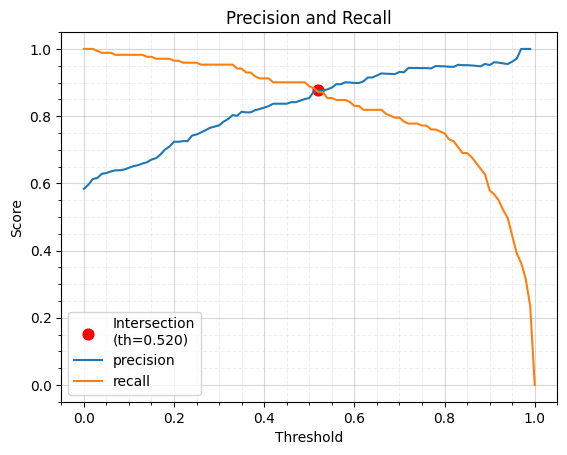

In [12]:
plt.scatter(best.threshold, best.p, color='red', s=60, label=f'Intersection\n(th={best.threshold:.3f})')

plt.plot(df_scores.threshold, df_scores['p'], label='precision')
plt.plot(df_scores.threshold, df_scores['r'], label='recall')

plt.legend()

plt.grid(True, which='major', linestyle='-', alpha=0.5)
plt.grid(True, which='minor', linestyle='--', alpha=0.2)
plt.minorticks_on()

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall')

###**<font color='red'>Question 4: F1 score</font>**
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$
F_1 = \frac{2 \cdot P \cdot R}{P + R}
$$

Where *P* is precision and *R* is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?
- 0.14
- 0.34
- <font color='green'>0.54</font> ✅
- 0.74

In [13]:
df_scores['f1'] =  2 * df_scores['p'] * df_scores['r'] / (df_scores['p'] + df_scores['r'])
df_scores.loc[df_scores["f1"].idxmax()][["threshold"]]

,51
threshold,0.51


###**<font color='red'>Question 5: 5-Fold CV</font>**
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

    KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?
- 0.0001
- 0.006
- <font color='green'>0.06</font> ✅
- 0.36

In [14]:
def train(df_train, y_train, C=1.0, scaler=None):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    fitted_scaler = None
    if scaler is not None:
        fitted_scaler = clone(scaler).fit(X_train)
        X_train = fitted_scaler.transform(X_train)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, fitted_scaler, model

def predict(df, dv, scaler, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')
    X = dv.transform(dicts)
    if scaler is not None:
        X = scaler.transform(X)
    return model.predict_proba(X)[:, 1]

In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

use_scaler = False
base_scaler = StandardScaler() if use_scaler else None

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, fitted_scaler, model = train(df_train, y_train, C=1.0, scaler=base_scaler)
    y_pred = predict(df_val, dv, fitted_scaler, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('AUC = %0.3f ± %0.3f' % (np.mean(scores), np.std(scores)))

AUC = 0.822 ± 0.036


###**<font color='red'>Question 6: Hyperparameter Tuning</font>**
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following `C` values: `[0.000001, 0.001, 1]`
- Initialize `KFold` with the same parameters as previously
- Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?
- 0.000001
- <font color='green'>0.001</font> ✅
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [16]:
n_splits = 5
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    use_scaler = False
    base_scaler = StandardScaler() if use_scaler else None

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, fitted_scaler, model = train(df_train, y_train, C=C, scaler=base_scaler)
        y_pred = predict(df_val, dv, fitted_scaler, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s, auc = %0.3f ± %0.6f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, auc = 0.560 ± 0.023798
C=0.001, auc = 0.867 ± 0.028746
C=1, auc = 0.822 ± 0.035807
